<h3> Kacper Moll
<h3> July 2023

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [ ]:
# !pip install transformers

<h1> 1. Detect Language

<h1> Importing libraries defining constant values and helper functions

In [ ]:
import time # For creating subfolders while saving a model
import pandas as pd # For data exploration and preprocessing
import numpy as np # For numerical computations
import tensorflow as tf # For buliding the model, deepl learning library
import matplotlib.pyplot as plt # For visualisation
from sklearn.model_selection import train_test_split # For splitting the data into training and testing sets
from sklearn.preprocessing import LabelEncoder # For label encoding the target variable
from sklearn.utils import resample # For resampling imbalanced data
from sklearn.metrics import classification_report, accuracy_score # For generating a classification report to evaluate the model
from transformers import BertTokenizerFast, TFBertForSequenceClassification # Hugging Face's BERT model and tokenizer
from tensorflow.keras.callbacks import EarlyStopping # For early stopping during model training

In [ ]:
LOAD_PATH = '/content/drive/MyDrive/NLP-FinalVersion'
OUTPUT_PATH = '/content/drive/MyDrive/NLP-FinalVersion/SavedModel'

In [ ]:
def show_statistics_from_dataframe(df: pd.DataFrame) -> None:
    """
    Show statistics for each language in the dataframe.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing 'sentence' and 'language' columns.
    """
    statistics = {}

    print('General DataFrame Information')
    print('-----------------------------')
    print(f'Total rows in DataFrame: {len(df)}')
    print('-----------------------------')
    print(f'Missing values:\n{df.isnull().sum()}')
    print('-----------------------------')
    df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
    print(f'Length of the sentences:\n{df["sentence_length"].describe()}')
    print('-----------------------------')

    # Calculate statistics for each language
    for language, group in df.groupby('language'):
        sentences = group['sentence']
        word_list = ' '.join(sentences).split()

        number_of_sentences = len(sentences)
        number_of_words = len(word_list)
        number_of_unique_words = len(set(word_list))
        sample_extract = sentences.iloc[0][:50]  # limit the sample extract to 50 characters

        statistics[language] = {
            'Number of sentences': number_of_sentences,
            'Number of words': number_of_words,
            'Number of unique words': number_of_unique_words,
            'Sample extract': sample_extract + '...'
        }

    # Print the statistics for each language
    for language, stats in statistics.items():
        print(f'\nLanguage: {language}')
        print('-----------------------')
        for stat_name, stat_value in stats.items():
            print(f'{stat_name}: {stat_value}')

def tokenize_and_encode(sentence: str) -> list:
    """
    Tokenize and encode a sentence using the given tokenizer.

    Parameters:
        sentence (str): The input sentence to be tokenized and encoded.

    Returns:
        list: The list of encoded tokens for the sentence.
    """
    return tokenizer.encode(sentence, truncation=True, max_length=128, padding="max_length")

<h1> Loading the data </h1>

The data for this language detection task is sourced from Tatoeba (https://tatoeba.org/en/downloads), which provides a collection of sentences and translations for various languages. I chose this dataset because it contains large sentences for each language, making it an ideal case for the specific task of language detection. Since I had limited computational resources available, I decided to norrow training into 4 different languages.
I specifically selected the following languages for the dataset due to their different language families, which can present diverse linguistic characteristics:

* Arabic (ara): Representing the Afroasiatic language family.
* English (eng): Representing the Germanic language family.
* Russian (rus): Representing the Slavic language family.
* Spanish (spa): Representing the Romance language family.

In [ ]:
# Load the data for each language
df_ara = pd.read_table(f'{LOAD_PATH}/ara_sentences.tsv', usecols=[1, 2], header=None, names=["language", "sentence"])
df_eng = pd.read_table(f'{LOAD_PATH}/eng_sentences.tsv', usecols=[1, 2], header=None, names=["language", "sentence"])
df_rus = pd.read_table(f'{LOAD_PATH}/rus_sentences.tsv', usecols=[1, 2], header=None, names=["language", "sentence"])
df_spa = pd.read_table(f'{LOAD_PATH}/spa_sentences.tsv', usecols=[1, 2], header=None, names=["language", "sentence"])

# Concatenate the dataframes for all languages into a single dataframe
df_full = pd.concat([df_ara, df_eng, df_rus, df_spa])

<h1> Data Exploration </h1>

Before proceeding with data preprocessing, let's explore the dataset to gain some basic insights and show sample sentences for each chosen language.

In [ ]:
show_statistics_from_dataframe(df_full)

General DataFrame Information
-----------------------------
Total rows in DataFrame: 3267660
-----------------------------
Missing values:
language    0
sentence    0
dtype: int64
-----------------------------
Length of the sentences:
count    3.267660e+06
mean     6.975867e+00
std      6.241676e+00
min      1.000000e+00
25%      5.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      3.750000e+03
Name: sentence_length, dtype: float64
-----------------------------

Language: ara
-----------------------
Number of sentences: 57894
Number of words: 264480
Number of unique words: 55283
Sample extract: ويل للكافرين...

Language: eng
-----------------------
Number of sentences: 1810114
Number of words: 13949552
Number of unique words: 194817
Sample extract: Let's try something....

Language: rus
-----------------------
Number of sentences: 1003443
Number of words: 5728835
Number of unique words: 289519
Sample extract: Один раз в жизни я делаю хорошее дело... И оно бес...

Language:

The provided code performs data exploration and presents the following insights:

The dataset contains a total of 3,267,660 rows (sentences).
There are no missing values in the 'language' and 'sentence' columns.
The sentences have varying lengths, with an average sentence length of approximately 6.98 words.
The minimum sentence length is 1 word, and the maximum sentence length is 3,750 words.

This data exploration provides an initial understanding of the dataset's size, basic statistics, and the distribution of sentences among the chosen languages.



<h1> Data Cleaning</h1>  

Fortunately, the dataset does not contain any HTML tags, HTTP links, or other noise that requires cleaning. Additionally, during data exploration, we observed that there are no NaN values present in the dataset.

For our specific language detection task, it is better not to remove stop words, numbers and punctuation from sentences. These elements can contain valuable information to identify specific languages and contribute to the characteristics of each language.

In [ ]:
df_full = df_full.sample(frac=1, random_state=42)
df_full.head()

,language,sentence,sentence_length
1172512,eng,He learns Berber all the time.,6
150327,spa,Se acabó todo el dinero.,5
762287,eng,Everyone you meet is fighting a battle you kno...,14
185144,rus,Я как ты.,3
550572,rus,Это ваших рук дело?,4


<h1> Data Preprocessing

<h3> The data is processed through the following steps:

* Downsampling: To balance the dataset, we downsample each language to 1000 sentences (due to comutational limiations), ensuring equal representation.

In [ ]:
# Downsample each language
df_eng_downsampled = resample(df_eng, replace=False, n_samples=1000, random_state=42)
df_rus_downsampled = resample(df_rus, replace=False, n_samples=1000, random_state=42)
df_spa_downsampled = resample(df_spa, replace=False, n_samples=1000, random_state=42)
df_ara_downsampled = resample(df_ara, replace=False, n_samples=1000, random_state=42)
# Combine all languages
df_full = pd.concat([df_eng_downsampled, df_rus_downsampled, df_spa_downsampled, df_ara_downsampled])
df_full = df_full.sample(frac=1, random_state=42)

* Label Encoding: The categorical 'language' labels are transformed into numerical 'lang_id' values using LabelEncoder.


In [ ]:
le = LabelEncoder()
df_full['lang_id'] = le.fit_transform(df_full['language'])

* Train-Test Split: The dataset is split into training and testing sets with an 80-20 ratio, ensuring similar class distribution in both sets.

In [ ]:
df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full['lang_id'])

* Tokenization: We use the 'bert-base-multilingual-cased' model's tokenizer, BertTokenizerFast, to tokenize the sentences.

* Token Encoding: The sentences are encoded into input IDs using the tokenizer's encode method.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
df_train['input_ids'] = df_train['sentence'].apply(tokenize_and_encode)
df_test['input_ids'] = df_test['sentence'].apply(tokenize_and_encode)


* Attention Masks: Attention masks are created to indicate actual tokens versus padding tokens, allowing BERT to handle variable-length sentences.

In [ ]:
df_train['attention_mask'] = df_train['input_ids'].apply(lambda x: [1 if i != tokenizer.pad_token_id else 0 for i in x])
df_test['attention_mask'] = df_test['input_ids'].apply(lambda x: [1 if i != tokenizer.pad_token_id else 0 for i in x])

<h1> Building and Fine-tuning Pre-trained Model </h1>

The chosen model for language detection is 'bert-base-multilingual-cased' due to its capability of handling multilingual tasks. This model is a pre-trained BERT model with a cased vocabulary, making it suitable for tasks that require case sensitivity, such as language detection.

The pre-trained BERT model, 'bert-base-multilingual-cased', is already well-equipped for sequence classification tasks. It includes a classification head that can directly handle the specific task of language detection without requiring additional layers.

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 177,856,516
Trainable params: 177,856,516
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
X_train = np.array(df_train['input_ids'].to_list())
y_train = np.array(df_train['lang_id'].to_list())
attention_masks_train = np.array(df_train['attention_mask'].to_list())

X_test = np.array(df_test['input_ids'].to_list())
y_test = np.array(df_test['lang_id'].to_list())
attention_masks_test = np.array(df_test['attention_mask'].to_list())


train_data = {"input_ids": X_train, "attention_mask": attention_masks_train}
val_data = {"input_ids": X_test, "attention_mask": attention_masks_test}

In [ ]:
model_history = model.fit(train_data, y_train,
                          validation_data=(val_data, y_test),
                          epochs=10,
                          batch_size=16,
                          callbacks=[early_stopping])

Epoch 1/10
200/200 [==============================] - 170s 532ms/step - loss: 0.0981 - accuracy: 0.9831 - val_loss: 0.0319 - val_accuracy: 0.9912
Epoch 2/10
200/200 [==============================] - 88s 440ms/step - loss: 0.0221 - accuracy: 0.9959 - val_loss: 0.0119 - val_accuracy: 0.9987
Epoch 3/10
200/200 [==============================] - 91s 454ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0113 - val_accuracy: 0.9987
Epoch 4/10
200/200 [==============================] - 89s 446ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0111 - val_accuracy: 0.9987
Epoch 5/10
200/200 [==============================] - 93s 463ms/step - loss: 9.8811e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9987
Epoch 6/10
200/200 [==============================] - 90s 449ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0116 - val_accuracy: 0.9987
Epoch 7/10
200/200 [==============================] - 94s 469ms/step - loss: 5.9134e-04 - accuracy: 1.0000 - val_loss: 0.0120

<h1> Visual presentation of the training process

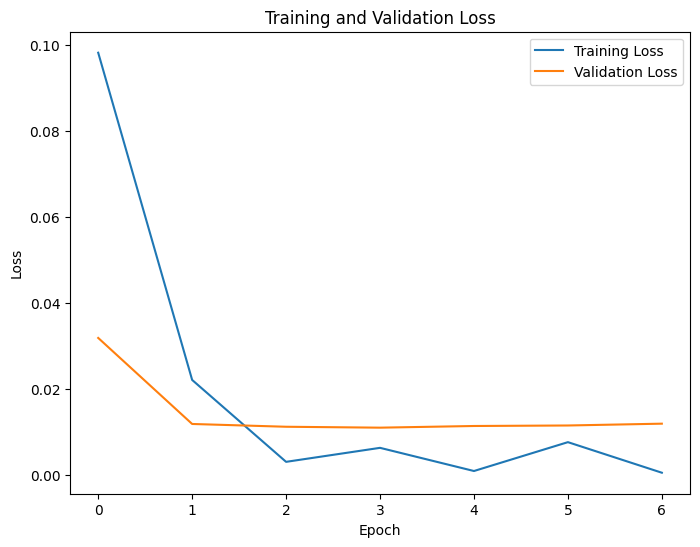

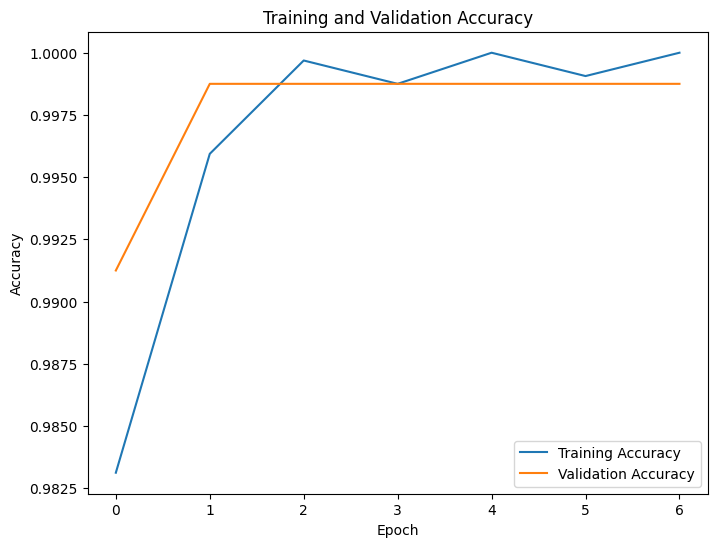

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

<h3> Saving Model </h3>

Each model version is saved in different subfolder

In [ ]:
model.save_pretrained(OUTPUT_PATH+f'/{time.time()}')

<h1> 2. Analysis of results on the dataset

<h1> Evaluation </h1>

To demnostrate the results of fine-tuning I have choosen the most suitable metrics for our specific task of language detectionto, which are precision, recall, and F1-score for each language class. These metrics provide insights into how well the model performs in correctly identifying each language.

In the context of language detection, precision represents the accuracy of the positive predictions for a particular language class. Recall indicates the proportion of actual instances of a language class that the model correctly identifies. F1-score is the harmonic mean of precision and recall and provides a balanced evaluation metric, considering both false positives and false negatives.

In [ ]:
y_pred = model.predict(val_data)
y_pred_labels = np.argmax(y_pred.logits, axis=1)

# Generating the classification report
target_names = le.classes_
classification_rep = classification_report(y_test, y_pred_labels, target_names=target_names)

# Calculation of overall accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

25/25 [==============================] - 6s 233ms/step


In [ ]:
print("Classification Report:")
print(classification_rep)
print("\nOverall Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

         ara       1.00      0.99      1.00       200
         eng       1.00      1.00      1.00       200
         rus       1.00      1.00      1.00       200
         spa       1.00      1.00      1.00       200

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Overall Accuracy: 0.99875


<h1> Demonstration how to use the model using predict_language function

In [ ]:
def predict_language(sentence, model, tokenizer, le):
    # tokenize the sentence
    inputs = tokenizer.encode_plus(sentence, return_tensors='tf', truncation=True, max_length=128, padding="max_length")

    # convert to tensors
    input_ids = tf.convert_to_tensor(inputs['input_ids'], dtype=tf.int32)
    attention_mask = tf.convert_to_tensor(inputs['attention_mask'], dtype=tf.int32)

    logits = model(input_ids, attention_mask).logits
    probabilities = tf.nn.softmax(logits, axis=-1).numpy()[0]

    # geting the language with the highest probability
    predicted_language_id = np.argmax(probabilities)

    # finding the corresponding language name
    predicted_language = le.inverse_transform([predicted_language_id])

    return predicted_language[0]

In [ ]:
sample_sentences = [
    "Yesterday was a very successful day.",  # English
    "Las vacaciones en España son geniales.",        # Spanish
    "Hello, how are you?",     # English
    "Столица России Москва",         # Russian
    "ما اسمك؟",                # Arabic
    "¿Ya viste la nueva película de Barbie?",         # Spanish
    "ما هي خططك لهذا اليوم؟",        # Arabic
    "Привет, как дела?",      # Russian
    "خبز الأفوكادو هو إفطاري المفضل",        # Arabic
    "I wonder what's for lunch today..."          # English
]

In [ ]:
predicted_languages = [predict_language(sentence, model, tokenizer, le) for sentence in sample_sentences]

In [ ]:
print("Sample Sentences and Predicted Languages:")
for sentence, predicted_language in zip(sample_sentences, predicted_languages):
    print(f"Sentence: '{sentence}'\nPredicted Language: {predicted_language}\n")

Sample Sentences and Predicted Languages:
Sentence: 'Yesterday was a very successful day.'
Predicted Language: eng

Sentence: 'Las vacaciones en España son geniales.'
Predicted Language: spa

Sentence: 'Hello, how are you?'
Predicted Language: eng

Sentence: 'Столица России Москва'
Predicted Language: rus

Sentence: 'ما اسمك؟'
Predicted Language: ara

Sentence: '¿Ya viste la nueva película de Barbie?'
Predicted Language: spa

Sentence: 'ما هي خططك لهذا اليوم؟'
Predicted Language: ara

Sentence: 'Привет, как дела?'
Predicted Language: rus

Sentence: 'خبز الأفوكادو هو إفطاري المفضل'
Predicted Language: ara

Sentence: 'I wonder what's for lunch today...'
Predicted Language: eng




**As we can see from the above evaluation and prediction presentation, the fine-tuned model performs incredibly well with the language detection task.**
⚡ 🎆 😀